In [2]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import sys
sys.path.append('../')
from jupyter_utils import *

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()
pd.set_option('display.max_rows', None)

from matplotlib.patches import PathPatch
from matplotlib.path import Path

# Lauren's colors
L_colors = ['red', 'darkorange', 'limegreen', 'green', 'deepskyblue', 'blue', 'black']
L_linestyles = ['solid', 'dashed']
L_markers = ['s', '^', 'v', 'd', 'P', "X", "*"]

In [3]:
# closure test? i.e. there is truth pythia data somewhere to compare to
closure = True

# define binnings
n_bins = [20, 20, 6] # WARNING RooUnfold seg faults if too many bins used
binning = [np.logspace(-5,0,n_bins[0]+1), \
            np.logspace(-2.09,0,n_bins[1]+1), \
            np.array([5, 20, 40, 60, 80, 100, 150]).astype(float) ]
print(binning[0])
print(binning[1])
bincenters = [ get_log_bincenters(binning[0]), get_log_bincenters(binning[1]), get_lin_bincenters(binning[2]) ]
binwidths = [ get_binwidths(a) for a in binning ]

labels = ["energy weight", "$R_L$", "jet $p_T$"]

n_iter = 5

[1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04
 1.00000000e-03 1.77827941e-03 3.16227766e-03 5.62341325e-03
 1.00000000e-02 1.77827941e-02 3.16227766e-02 5.62341325e-02
 1.00000000e-01 1.77827941e-01 3.16227766e-01 5.62341325e-01
 1.00000000e+00]
[0.00812831 0.01033951 0.01315225 0.01673016 0.02128139 0.02707073
 0.03443499 0.04380261 0.05571857 0.07087613 0.09015711 0.11468325
 0.14588143 0.18556668 0.23604782 0.30026174 0.38194427 0.48584753
 0.6180164  0.78614019 1.        ]


In [4]:
# file defs, hist imports

f_unfolded = ur.open("./unfolded_fr_new.root")
f_preunfold = ur.open("./preunfold_fr_new.root")

# Data, reco [theta_unknown_S]
h3_raw = f_preunfold["raw"]
h1_raw = f_preunfold["raw1D"]

# MC, reco [theta0_S]
h3_reco = f_preunfold["reco"]
h1_true = f_preunfold["reco1D"]

# MC, true [theta0_G]
h3_gen = f_preunfold["gen"]
h1_gen = f_preunfold["gen1D"]

# Data, true [theta_unknown_G]
# NO TRUE DATA HERE

h3_unfolded = []
#h1_unfolded = [] TODO add in h1 unfolded support
for i in range(1,n_iter+1):
    h3_unfolded.append(f_unfolded["Baysian_Unfoldediter{}".format(i)])


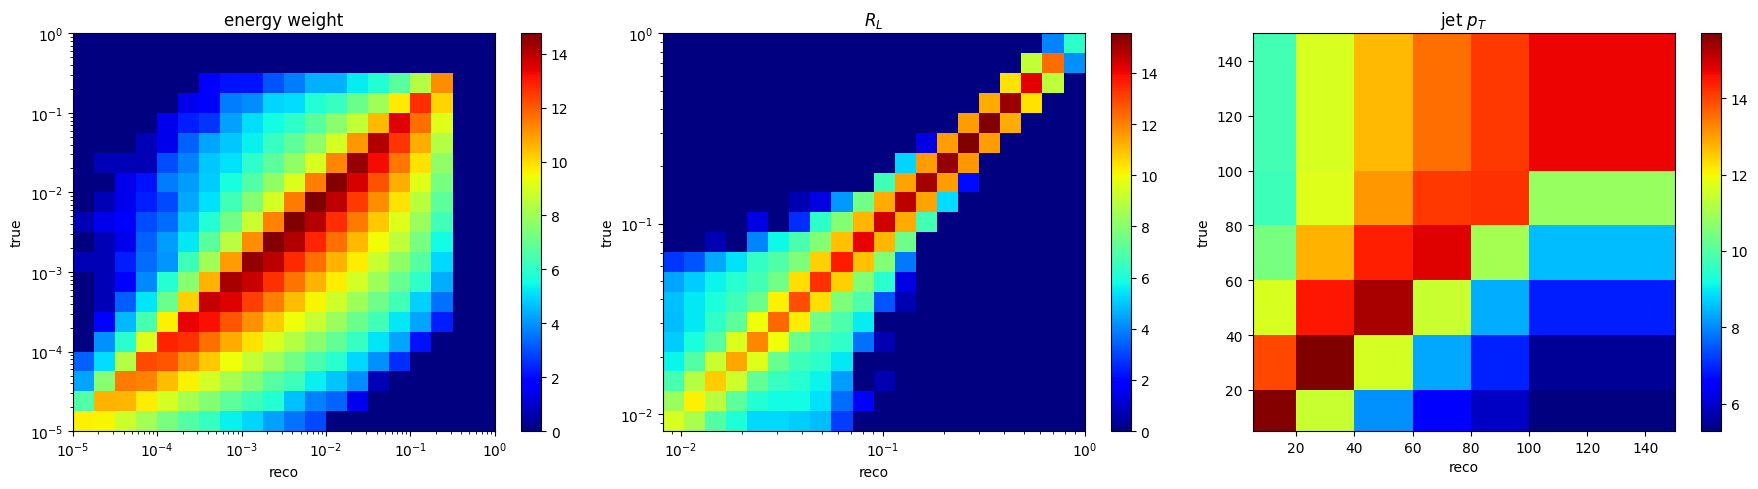

In [5]:
def FindBin(binx, biny, binz):
    assert binx < n_bins[0] and biny < n_bins [1] and binz < n_bins[2] \
            and 0 <= binx and 0 <= biny and 0 <= binz
    return binx + n_bins[0]*(biny + n_bins[1]*binz)

def FindIndex(bin_n):
    binz = bin_n // (n_bins[0] * n_bins[1])
    bin_n -= binz * (n_bins[0] * n_bins[1])

    biny = bin_n // n_bins[0]
    binx = bin_n % n_bins[0]

    return binx, biny, binz
    

matrix = f_unfolded["matrix"].values()
matrix1D = f_unfolded["matrix1D"].values()

[matrixx, matrixy, matrixz] = [np.zeros((n_bins[i], n_bins[i])) for i in range(3)]

N = n_bins[0]*n_bins[1]*n_bins[2]

for i in range(n_bins[0]):
    for j in range(n_bins[1]):
        for k in range(n_bins[2]):

            reco_bin = FindBin(i, j, k)
            for m in range(N):
                
                binx, biny, binz = FindIndex(m)
                bincontent = matrix[reco_bin][m]

                matrixx[i][binx] += bincontent
                matrixy[j][biny] += bincontent
                matrixz[k][binz] += bincontent

matricies = [matrixx, matrixy, matrixz]

# print response matricies

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    ax = axes[i]

    # Plot histograms
    #ax.imshow(matrix.values(), origin='lower', extent=[binning[0][0], binning[0][-1], binning[0][0], binning[0][-1]], cmap='viridis')
    h = matricies[i]
    plot = ax.pcolormesh(binning[i], binning[i], np.log(h, out=np.zeros_like(h), where=(h!=0)).T, cmap='jet')
    ax.set_title(labels[i])
    ax.set_xlabel('reco')
    ax.set_ylabel('true')

    if i in [0,1]:
        ax.set_xscale('log')
        ax.set_yscale('log')

    fig.colorbar(plot)


# Show plot
plt.tight_layout()
plt.show()

In [6]:
proj = lambda a : np.array([projectionX(a.values()), projectionY(a.values()), projectionZ(a.values())])
proj_err = lambda a : np.array([projectionX(a.errors()), projectionY(a.errors()), projectionZ(a.errors())])

theta0_G = proj(h3_gen)
theta0_S = proj(h3_reco)
theta_unknown_S = proj(h3_raw)

theta_unfolded = [proj(a) for a in h3_unfolded]

theta0_G_err = proj_err(h3_gen)
theta0_S_err = proj_err(h3_reco)
theta_unknown_S_err = proj_err(h3_raw)

theta_unfolded_err = [proj_err(a) for a in h3_unfolded]

matrixify = lambda A : projectionXY(A.values()).T
matrixify_err = lambda A: projectionXY(A.errors()).T

U_unfolded = [matrixify(A) for A in h3_unfolded]
U_unfolded_err = [matrixify_err(A) for A in h3_unfolded]

print(theta0_G)


[array([  98584.,  233582.,  486658.,  915466., 1578090., 2488686.,
        3607254., 4824812., 5951730., 6754102., 7026318., 6650778.,
        5674712., 4271216., 2771108., 1480640.,  586476.,  120080.,
              0.,       0.])
 array([5.822000e+04, 9.241400e+04, 1.459880e+05, 2.268860e+05,
        3.505740e+05, 5.306120e+05, 7.891900e+05, 1.158222e+06,
        1.657034e+06, 2.322682e+06, 3.186252e+06, 4.270600e+06,
        5.605344e+06, 7.153534e+06, 8.719078e+06, 9.432064e+06,
        6.598548e+06, 2.697552e+06, 5.222860e+05, 3.212000e+03])
 array([10932198., 12156136., 10306658.,  7828596.,  5678072.,  8618632.])]


/tmp/ipykernel_2265785/1209755565.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  proj = lambda a : np.array([projectionX(a.values()), projectionY(a.values()), projectionZ(a.values())])
/tmp/ipykernel_2265785/1209755565.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  proj_err = lambda a : np.array([projectionX(a.errors()), projectionY(a.errors()), projectionZ(a.errors())])


In [7]:
# get total number of jets, manually inputted from 1D jet unfolding

N_jets = 1024492
N_jets_err = 1070

(3,)
[5.822000e+04 9.241400e+04 1.459880e+05 2.268860e+05 3.505740e+05
 5.306120e+05 7.891900e+05 1.158222e+06 1.657034e+06 2.322682e+06
 3.186252e+06 4.270600e+06 5.605344e+06 7.153534e+06 8.719078e+06
 9.432064e+06 6.598548e+06 2.697552e+06 5.222860e+05 3.212000e+03]
[0.00812831 0.01033951 0.01315225 0.01673016 0.02128139 0.02707073
 0.03443499 0.04380261 0.05571857 0.07087613 0.09015711 0.11468325
 0.14588143 0.18556668 0.23604782 0.30026174 0.38194427 0.48584753
 0.6180164  0.78614019 1.        ]
21
(array([5.822000e+04, 9.241400e+04, 1.459880e+05, 2.268860e+05,
       3.505740e+05, 5.306120e+05, 7.891900e+05, 1.158222e+06,
       1.657034e+06, 2.322682e+06, 3.186252e+06, 4.270600e+06,
       5.605344e+06, 7.153534e+06, 8.719078e+06, 9.432064e+06,
       6.598548e+06, 2.697552e+06, 5.222860e+05, 3.212000e+03]), array([0.00812831, 0.01033951, 0.01315225, 0.01673016, 0.02128139,
       0.02707073, 0.03443499, 0.04380261, 0.05571857, 0.07087613,
       0.09015711, 0.11468325, 0.145881

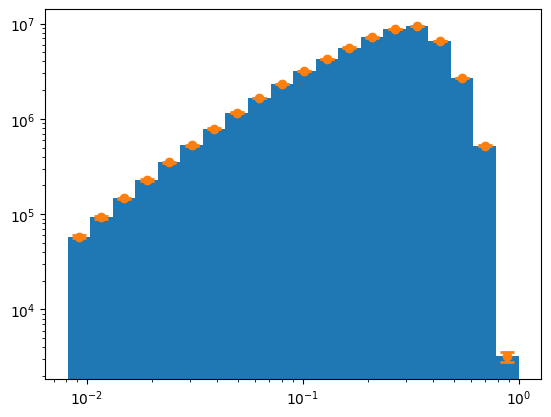

In [8]:
print(theta0_G.shape)
print(theta0_G[1])
print(binning[1])
print(len(binning[1]))

print(plt.hist(binning[1][:-1], binning[1], weights=theta0_G[1]))
print(len(binning[1][:-1]))
print(len(theta0_G_err[1]))
plt.errorbar(bincenters[1], theta0_G[1], yerr=theta0_G_err[1], capsize=5, capthick=2, fmt='o', linestyle="None")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [9]:
for iteration in range(n_iter):
    print(theta_unfolded[iteration][1])

print()

[3.54463430e+04 4.94994398e+04 7.14035776e+04 1.05365452e+05
 1.59377180e+05 2.51405523e+05 3.92645374e+05 6.07927538e+05
 9.60107120e+05 1.52965547e+06 2.40103564e+06 3.74563845e+06
 5.76191145e+06 8.63601549e+06 1.22273277e+07 1.52221204e+07
 1.21393476e+07 5.42844831e+06 1.00347320e+06 1.14179324e+04]
[4.01041564e+04 5.19770328e+04 7.33413870e+04 1.05363796e+05
 1.60181861e+05 2.54486306e+05 3.98794912e+05 6.13533586e+05
 9.68035903e+05 1.54910878e+06 2.42696664e+06 3.78434047e+06
 5.82767088e+06 8.73443951e+06 1.23605385e+07 1.54007462e+07
 1.23480834e+07 5.56635665e+06 1.04964234e+06 1.25233568e+04]
[4.28238966e+04 5.21215581e+04 7.31791330e+04 1.04398921e+05
 1.60065566e+05 2.55811113e+05 4.01447327e+05 6.15037143e+05
 9.70165925e+05 1.55610833e+06 2.43566387e+06 3.79564035e+06
 5.84706163e+06 8.76326652e+06 1.23969554e+07 1.54434099e+07
 1.23838330e+07 5.58442249e+06 1.05428137e+06 1.25173286e+04]
[4.47914690e+04 5.17591710e+04 7.28046997e+04 1.03551866e+05
 1.59961970e+05 2.565

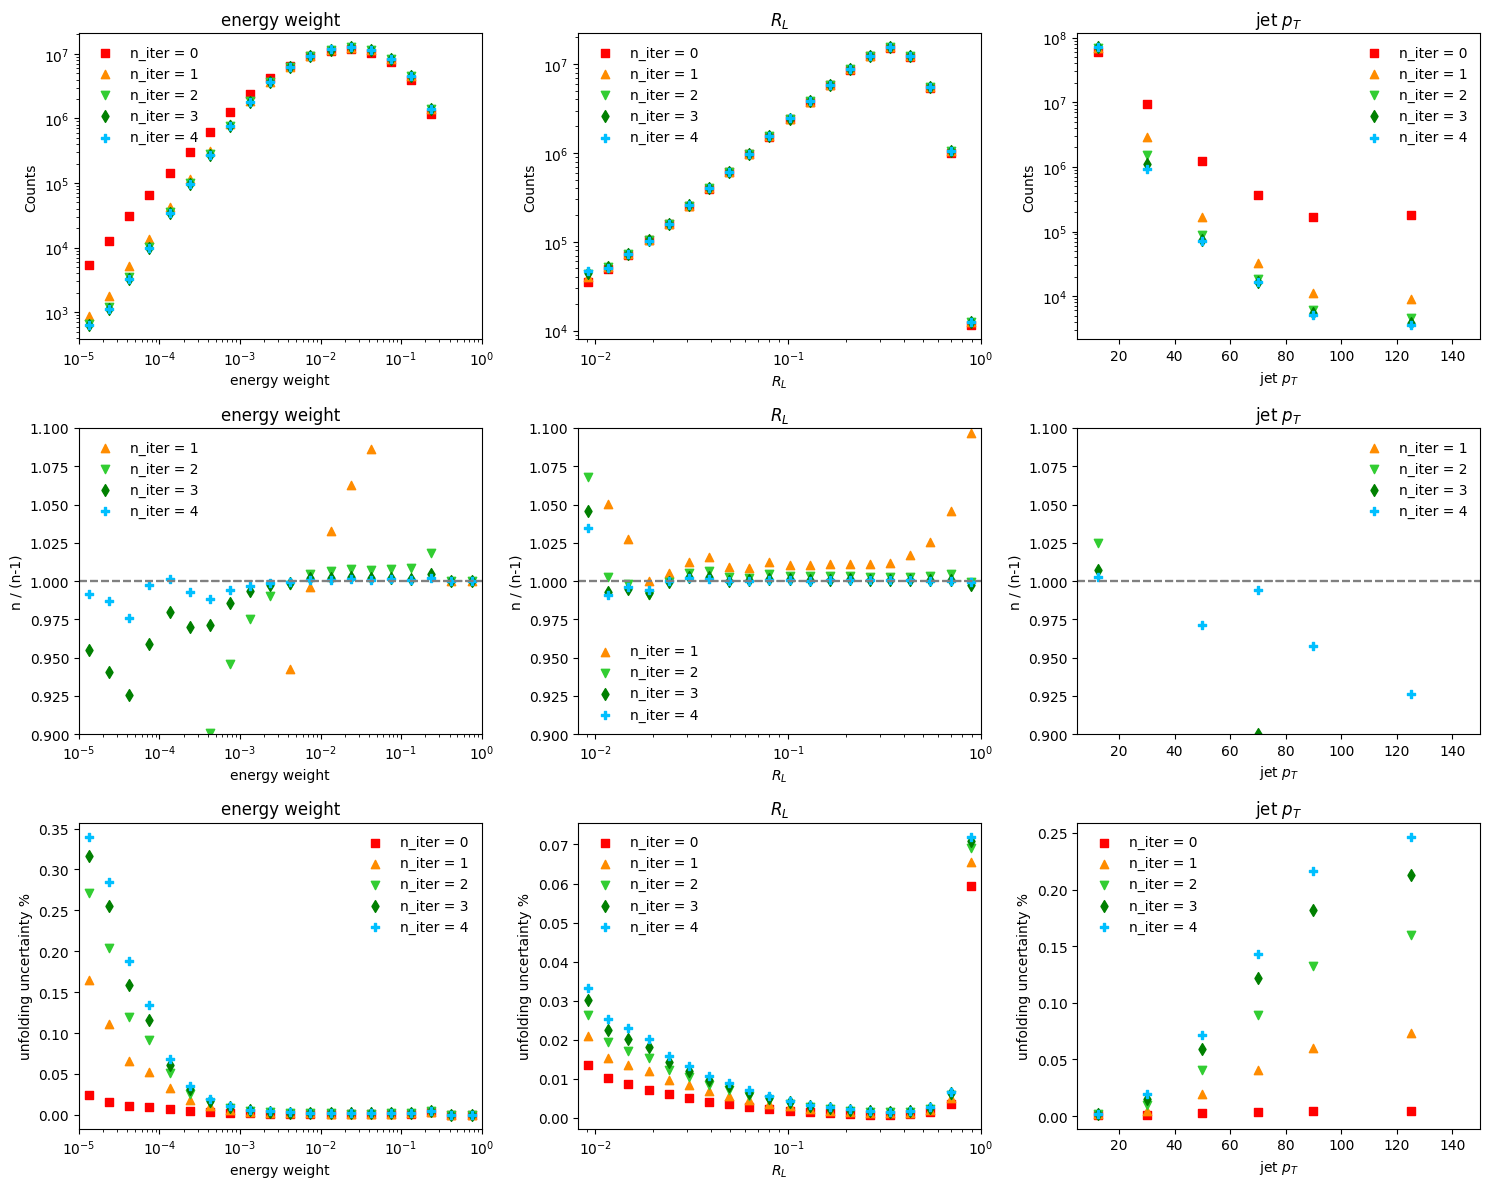

In [10]:
############################## UNFOLDED DISTRIBUTIONS ############################
# individual distros

it = 5

fig, axes = plt.subplots(3, 3, figsize=(15,12))

# ROW 1: raw distributions
for i in range(3):
    ax = axes[0, i]

    for iteration in range(it):
        ax.scatter(bincenters[i], theta_unfolded[iteration][i],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
        ax.set_ylabel("Counts")

        #ax.errorbar(bincenters[i], theta_unfolded[iteration][:,i], yerr=theta_unfolded_err[iteration][:,i], capsize=5, capthick=2, fmt='o', linestyle="None", color=L_colors[iteration])
        
        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


# ROW 2: convergence plot (n / n - 1)
for i in range(3):
    ax = axes[1, i]

    for iteration in range(1,it):
    
        yvals = safe_divide(theta_unfolded[iteration][i] , theta_unfolded[iteration-1][i], filler=1)
        ax.scatter(bincenters[i], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

        ax.hlines(y=1, xmin=binning[i][0], xmax=binning[i][len(binning[i])-1], color='grey', linestyle='--')

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("n / (n-1)")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_ylim([0.9, 1.1])
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


# ROW 3: statistical error %
for i in range(3):
    ax = axes[2, i]

    for iteration in range(it):
        
        yvals = safe_divide(theta_unfolded_err[iteration][i], theta_unfolded[iteration][i])
        ax.scatter(bincenters[i], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("unfolding uncertainty %")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


fig.tight_layout()
plt.show()

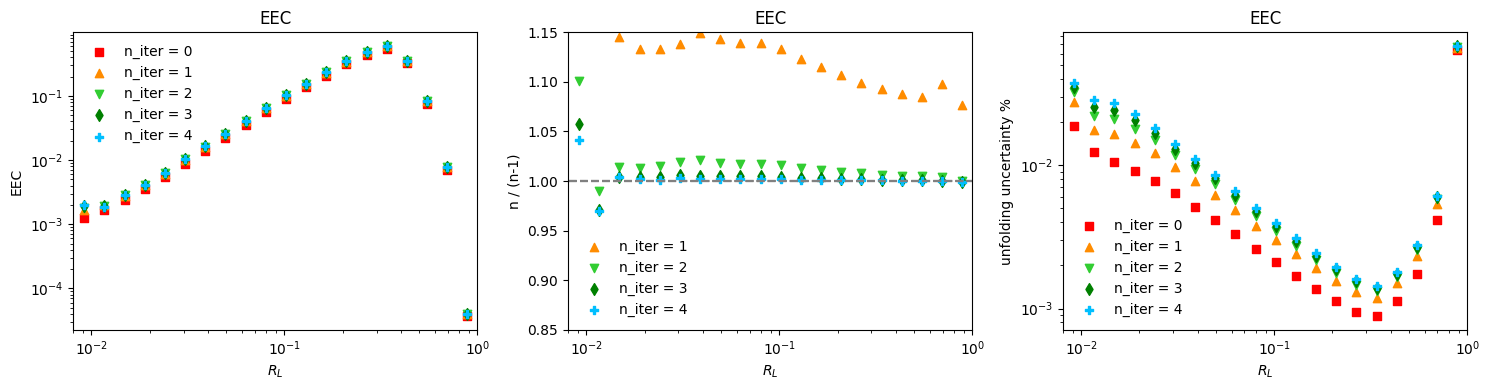

In [11]:
############################## UNFOLDED DISTRIBUTIONS ############################
# EEC distros

it = 5

fig, axes = plt.subplots(1, 3, figsize=(15,4))

# EEC weight calculation:
# w_n = U * b, U is matrixfied RL-energy weight 2D histogram, b is bincenters of energy weights

unfolded_EEC = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded[iteration]] for iteration in range(len(theta_unfolded))]) / N_jets
unfolded_EEC_err = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded_err[iteration]] for iteration in range(len(theta_unfolded))]) / N_jets

# TODO propagate error from N_jets here, i dont wanna do ittttt

# COL 1: raw EEC distribution WITH relative error over data, true underneath
ax = axes[0]

rl_lims = ax.set_xlim([8E-3, 1])

for iteration in range(it):

    ax.scatter(bincenters[1], unfolded_EEC[iteration],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
    ax.set_ylabel("EEC")
    
    ax.set_title("EEC")
    ax.set_xlabel(labels[1])

    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)
    
# COL 2: convergence plot (n / n - 1)
ax = axes[1]

for iteration in range(1,it):

    yvals = safe_divide(unfolded_EEC[iteration], unfolded_EEC[iteration-1], filler=1)
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.hlines(y=1, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("n / (n-1)")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_ylim([0.85, 1.15])
    ax.set_xlim(rl_lims)


# COL 3: statistical error %
ax = axes[2]

for iteration in range(it):
    
    yvals = safe_divide(unfolded_EEC_err[iteration], unfolded_EEC[iteration])
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("unfolding uncertainty %")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)


fig.tight_layout()
plt.show()


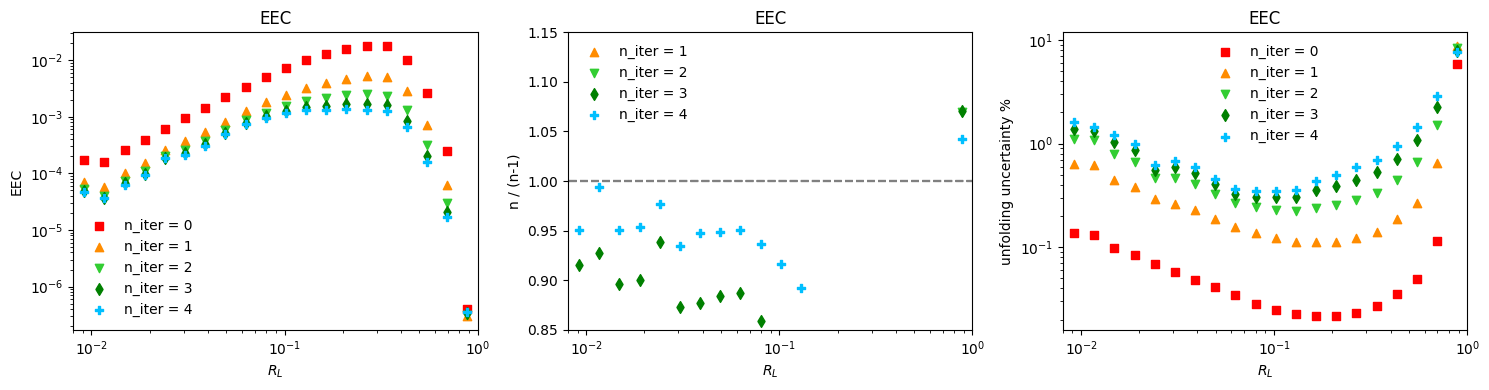

In [13]:
############################## UNFOLDED DISTRIBUTIONS ############################
# EEC distros

it = 5

fig, axes = plt.subplots(1, 3, figsize=(15,4))

# apply pt cut
ptcut_bins = [1, 2]
U_unfolded_cut = [zslice(A.values(), ptcut_bins[0], ptcut_bins[1]).T for A in h3_unfolded]

# EEC weight calculation:
# w_n = U * b, U is matrixfied RL-energy weight 2D histogram, b is bincenters of energy weights

unfolded_EEC = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded_cut[iteration]] for iteration in range(len(theta_unfolded))]) / N_jets

# TODO propagate error from N_jets here, i dont wanna do ittttt

# COL 1: raw EEC distribution WITH relative error over data, true underneath
ax = axes[0]

rl_lims = ax.set_xlim([8E-3, 1])

for iteration in range(it):

    ax.scatter(bincenters[1], unfolded_EEC[iteration],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
    ax.set_ylabel("EEC")
    
    ax.set_title("EEC")
    ax.set_xlabel(labels[1])

    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)
    
# COL 2: convergence plot (n / n - 1)
ax = axes[1]

for iteration in range(1,it):

    yvals = safe_divide(unfolded_EEC[iteration], unfolded_EEC[iteration-1], filler=1)
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.hlines(y=1, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("n / (n-1)")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_ylim([0.85, 1.15])
    ax.set_xlim(rl_lims)


# COL 3: statistical error %
ax = axes[2]

for iteration in range(it):
    
    yvals = safe_divide(unfolded_EEC_err[iteration], unfolded_EEC[iteration])
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("relative unfolding uncertainty")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)


fig.tight_layout()
plt.show()
